In [1]:
import pathlib
import sys
module_dir = pathlib.Path("").parent.resolve()
root_dir = module_dir.parent
source_dir = root_dir.joinpath("source")
model_dir = root_dir.joinpath("model")
asvlite_wrapper_dir = root_dir.joinpath("dependency", "ASVLite", "wrapper", "cython")
sys.path.insert(0, str(source_dir))
sys.path.insert(0, str(asvlite_wrapper_dir))

In [2]:
import pyproj
import ctypes
import cartopy.crs as ccrs
from datetime import datetime, timedelta
from pathlib import Path
import os
import epsg
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm 
import cds
from netcdf import NetCDF_wave, NetCDF_current
from rudder_controller import Rudder_PID_controller
from sea_surface import py_Sea_surface
from asv import py_Asv_specification, py_Asv
from geometry import py_Coordinates_3D
from geometry import py_normalise_angle_PI, py_normalise_angle_2PI
from thrust_calibrator import Thrust_calibrator

In [3]:
# Simulation output directory
output_dir = root_dir.joinpath(*"results/glider_thrust/benjamin_in_freda_1".split("/"))  
output_dir.mkdir(parents=True, exist_ok=True)

In [4]:
# Time
time_step_size = 40.0 # Simulation time step size in milliseconds
start_time = datetime(2012, 12, 28, 12) # Start time of simulation
end_time   = datetime(2013, 1, 4)# End time of simulation

year_1 = str(start_time.year)
year_2 = str(end_time.year)
month_1 = str(start_time.month).zfill(2)
month_2 = str(end_time.month).zfill(2)

In [5]:
# Downloads the wave data for the period 
nc_data_wave = {}
nc_files = ["{}_{}.nc".format(year_1, month_1), "{}_{}.nc".format(year_2, month_2)]
for file in nc_files:
    cds_dir = root_dir.joinpath("data", "cds", "pacx", "waves")
    nc_file = cds_dir.joinpath(file)
    if not os.path.exists(str(nc_file)):
        # Make the cds dir if it does not exist.
        cds_dir.mkdir(parents=True, exist_ok=True)
        # nc file does not exist, download it.
        year, month = file[:-3].split("_")
        north = 40
        south = -40
        east = 180
        west = -180
        cds.get_wave_data(int(year), int(month), north, south, east, west, str(nc_file))
    else:
        print("Found {}".format(file))
    # Load the nc file
    nc_data_wave[file] = NetCDF_wave(nc_file)

Found 2012_12.nc
Found 2013_01.nc


In [6]:
# Downloads the ocean current data for the period 
nc_data_current = {}
tar_files = ["{}_{}.tar.gz".format(year_1, month_1), "{}_{}.tar.gz".format(year_2, month_2)]
for file in tar_files:
    cds_dir = root_dir.joinpath("data", "cds", "pacx", "ocean_currents")
    tar_file = cds_dir.joinpath(file)
    if not os.path.exists(str(tar_file)):
        # Make the cds dir if it does not exist.
        cds_dir.mkdir(parents=True, exist_ok=True)
        # tar file does not exist, download it.
        year, month = file[:-7].split("_")
        cds.get_ocean_current_data(int(year), int(month), str(tar_file))
    else:
        print("Found {}".format(file))
    # Load the nc file
    for year, month in [(year_1, month_1), (year_2, month_2)]:
        for day in range(1, 32):
            file_name = "{}_{}_{}.nc".format(year, str(month).zfill(2), str(day).zfill(2)) 
            nc_file = cds_dir.joinpath(file_name)
            if os.path.exists(nc_file):
                nc_data_current[file_name] = NetCDF_current(str(nc_file))

Found 2012_12.tar.gz
Found 2013_01.tar.gz


In [7]:
# Helper function to get wave data for a given location and time.
def get_wave_data_at(longitude, latitude, time):
    year = time.year
    month = time.month
    file_name = "{}_{}.nc".format(year, str(month).zfill(2))
    wave_hs, wave_dp = nc_data_wave[file_name].get_wave_data_at(longitude, latitude, time)
    return (wave_hs, wave_dp)

In [8]:
def get_ocean_current_at(longitude, latitude, time):
    year = time.year
    month = time.month
    day = time.day
    file_name = "{}_{}_{}.nc".format(year, str(month).zfill(2), str(day).zfill(2))
    v_zonal, v_meridional = nc_data_current[file_name].get_ocean_current_at(longitude, latitude, time)
    if v_zonal == None or v_meridional == None:
        print("Ocean current data not available for ({}, {}) at time {} in file {}".format(longitude, latitude, time, file_name))
        v_zonal, v_meridional = (0, 0)
    return (v_zonal, v_meridional)

In [9]:
# Load Benjamin's log file
log_file = root_dir.joinpath(*"data/pacx/logs/1.1/data/0-data/PacX_NODC_master_folder/benjamin/moseg_benjamin.txt".split("/"))
df = pd.read_csv(str(log_file))
df["Timestamp(UTC)"] = pd.to_datetime(df["Timestamp(UTC)"]) # Convert column Timestamp to datetime format

In [10]:
# Trim the dataframe to remove log of period that we are not interested in.
# Keep only the data between start_time and end_time of the storm.
df = df[(df["Timestamp(UTC)"] >= start_time) & (df["Timestamp(UTC)"] <= end_time)]
df.reset_index(drop=True, inplace=True)
i_start = df.first_valid_index() # Index of first row

pd.set_option('display.max_rows', None)
df

,Timestamp(UTC),Latitude,Longitude,Wave Height(meters),Wave Direction(degrees T),Average Wave Period(seconds),Dominant Wave Period(seconds)
0,2012-12-28 12:00:01,-17.7580,162.7603,2.0,25,6.1,8.0
1,2012-12-28 13:00:01,-17.7600,162.7496,1.8,42,5.9,8.0
2,2012-12-28 14:00:01,-17.7620,162.7385,2.0,31,6.1,7.5
3,2012-12-28 15:00:01,-17.7645,162.7256,2.0,64,5.7,6.4
4,2012-12-28 16:00:01,-17.7665,162.7155,1.9,54,5.5,7.1
5,2012-12-28 17:00:01,-17.7689,162.7036,2.1,59,5.9,6.7
6,2012-12-28 18:00:01,-17.7711,162.6923,2.1,44,5.5,7.1
7,2012-12-28 19:00:01,-17.7725,162.6843,2.1,52,5.6,6.7
8,2012-12-28 20:00:01,-17.7742,162.6767,2.0,49,5.3,7.1
9,2012-12-28 21:00:01,-17.7774,162.6714,2.4,24,5.6,8.0


In [11]:
thrust_calibrator = Thrust_calibrator("PC")

Found 2011_11.nc
Found 2011_12.nc
Found 2012_01.nc
Found 2012_02.nc
Found 2012_03.nc
Found 2012_04.nc
Found 2012_05.nc
Found 2012_06.nc
Found 2012_07.nc
Found 2012_08.nc
Found 2012_09.nc
Found 2012_10.nc
Found 2012_11.nc
Found 2012_12.nc
Found 2013_01.nc
Found 2013_02.nc
Found 2013_03.nc
Found 2011_11.tar.gz
Found 2011_12.tar.gz
Found 2012_01.tar.gz
Found 2012_02.tar.gz
Found 2012_03.tar.gz
Found 2012_04.tar.gz
Found 2012_05.tar.gz
Found 2012_06.tar.gz
Found 2012_07.tar.gz
Found 2012_08.tar.gz
Found 2012_09.tar.gz
Found 2012_10.tar.gz
Found 2012_11.tar.gz
Found 2012_12.tar.gz
Found 2013_01.tar.gz
Found 2013_02.tar.gz
Found 2013_03.tar.gz


In [12]:
# Wave glider specs
asv_spec = py_Asv_specification()
asv_spec.L_wl       = 2.1 # m
asv_spec.B_wl       = 0.6 # m
asv_spec.D          = 0.25 # m 
asv_spec.T          = 0.09 # m
asv_spec.max_speed  = 4.0 # m/s
asv_spec.disp       = 0.09 # m3
asv_spec.r_roll     = 0.2 # m
asv_spec.r_pitch    = 0.6 # m
asv_spec.r_yaw      = 0.6 # m
asv_spec.cog        = py_Coordinates_3D(1.05, 0.0, -3.0) # m

In [13]:
# Start position
start_position_GCS = py_Coordinates_3D(df.loc[i_start, " Longitude"], df.loc[i_start, " Latitude"])
x, y = epsg.GCS_to_PCS(start_position_GCS.x, start_position_GCS.y)
start_position_PCS = py_Coordinates_3D(x, y)

In [14]:
# Start attitude
lat1  = df.loc[i_start, " Latitude"]
long1 = df.loc[i_start, " Longitude"]
lat2  = df.loc[i_start+1, " Latitude"]
long2 = df.loc[i_start+1, " Longitude"]
geodesic = pyproj.Geod(ellps='WGS84')
fwd_azimuth, back_azimuth, distance = geodesic.inv(long1, lat1, long2, lat2)
fwd_azimuth = fwd_azimuth if fwd_azimuth >= 0.0 else (360 + fwd_azimuth)
start_attitude = py_Coordinates_3D(0.0, 0.0, math.pi/180.0 * fwd_azimuth) 

In [15]:
# Sea surface
wave_rand_seed = 1
count_component_waves = 21
wave_hs, wave_dp = get_wave_data_at(start_position_GCS.x, start_position_GCS.y, start_time) 
sea_surface = py_Sea_surface(wave_hs, wave_dp, wave_rand_seed, count_component_waves)

In [16]:
# Initialise the wave glider
asv = py_Asv(asv_spec, sea_surface, start_position_PCS, start_attitude)

In [17]:
# Initialise the rudder controller
rudder_controller = Rudder_PID_controller(asv_spec)
rudder_angle = 0.0

Loading rudder PID from file - /mnt/c/Users/tobyt/Projects/Soton/StormExplorers/models/rudder_PID
P,I,D =  [4.25 4.25 4.25]


In [18]:
# Waypoints
waypoints = []
for i in range(1, len(df)):
    waypoint_GCS = py_Coordinates_3D(df.loc[i, " Longitude"], df.loc[i, " Latitude"])
    x, y = epsg.GCS_to_PCS(waypoint_GCS.x, waypoint_GCS.y)
    waypoint_PCS = py_Coordinates_3D(x, y)
    waypoints.append(waypoint_PCS)

In [19]:
# Simulate till last waypoint
proximity_margin = 10.0 # m
i_waypoint = 0
df["Timestamp(simulated)"] = df["Timestamp(UTC)"] 
start_time = df.loc[0, "Timestamp(UTC)"] 
time = start_time - timedelta(milliseconds=40)
# Arrays to record timestamps, positions and currents for every minute of the simulation.
simulation_timestamps = []
simulated_path = []
currents = []

# Show a progress bar
pbar = tqdm(total = len(waypoints)-1)
pbar.set_description("Benjamin simulation progress")

# Simulate till last waypoint
has_not_reached_final_waypoint = True
while True:
    # Increment time
    time = time + timedelta(seconds=time_step_size/1000.0)
    # Check if reached the waypoint  
    position = asv.py_get_position_cog() # Get the current position in PCS.
    dx = position.x - waypoints[i_waypoint].x 
    dy = position.y - waypoints[i_waypoint].y 
    distance = math.sqrt(dx*dx + dy*dy) # m
    if distance <= proximity_margin:
        # Reached current waypoint
        pbar.update(1)
        df.loc[i_waypoint+1, "Timestamp(simulated)"] = time
        # Increment to next waypoint 
        if i_waypoint == len(waypoints)-1: 
            # Reached the final waypoint
            break
        else:
            i_waypoint += 1
    # Get the sea state and ocean current
    wg_longitude, wg_latitude = epsg.PCS_to_GCS(position.x, position.y)
    new_hs, new_dp = get_wave_data_at(wg_longitude, wg_latitude, time)
    v_zonal, v_meridional = get_ocean_current_at(wg_longitude, wg_latitude, time) 
    if new_hs == None or new_dp == None:
        print("{}: Wave data not available.".format(time))
        break
    # Compare the sea state with the current sea state
    current_hs = sea_surface.py_get_significant_height() # m
    current_dp = sea_surface.py_get_predominant_heading() # radians
    is_sea_state_same = (float(new_hs) == float(current_hs) and float(new_dp == current_dp))
    # If the sea state has changed then, set the new sea state in the wave glider
    if not is_sea_state_same:
        new_sea_surface = py_Sea_surface(new_hs, new_dp, wave_rand_seed, count_component_waves)
        asv.py_set_sea_state(new_sea_surface)                 
    # Set rudder angle
    rudder_angle = rudder_controller.get_rudder_angle(asv, waypoints[i_waypoint])
    # Set thrust tuning factor
    asv_attitude = asv.py_get_attitude()
    thrust_tuning_factor = thrust_calibrator.get_thrust_tuning_factor(new_hs, v_zonal, v_meridional, asv_attitude.z)
    asv.py_wg_set_thrust_tuning_factor(thrust_tuning_factor)
    # Record the time, position and current.  
    if time.second == 0 and time.microsecond == 0:
        simulated_path.append(position)
        simulation_timestamps.append(time)
        currents.append((v_zonal, v_meridional))
    # Compute dynamics
    try:
        asv.py_set_ocean_current(v_zonal, v_meridional)
        asv.py_wg_compute_dynamics(rudder_angle, time_step_size)
    except Exception as e:
        print(str(e))

pbar.close()

# Error in time for each waypoint
df["time_error(hrs)"] =  (df["Timestamp(UTC)"] - df["Timestamp(simulated)"]).apply(lambda row: row.total_seconds()/3600.0)
# Error in position for each time in the log
df["position_error(km)"] = 0.0
for i in range(len(df)):
    time = df.loc[i, "Timestamp(UTC)"]
    i_time = int((time - start_time).total_seconds()/60) # Because the arrays simulation_timestamps and simulated_path keeps records for every minute. 
    if i_time < len(simulation_timestamps):
        x1, y1 = epsg.GCS_to_PCS(df.loc[i, " Longitude"], df.loc[i, " Latitude"]) # Actual position
        x2, y2 = simulated_path[i_time].x, simulated_path[i_time].y # Simulated position for the same time
        delta_x = (x2 -x1) if (x2 * x1) >= 0 else (x2 + x1) 
        delta_y = (y2 -y1) if (y2 * y1) >= 0 else (y2 + y1) 
        df.loc[i, "position_error(km)"] = math.sqrt(delta_x**2 + delta_y**2)/1000
    else:
        df.loc[i, "position_error(km)"] = np.nan

# Write simulated path to file
df.to_csv("{}/simulated_log.csv".format(output_dir))
f = open("{}/simulated_path.csv".format(output_dir), "w")
f.write("x,y,timestamp\n")
for i in range(len(simulated_path)):
    f.write("{},{},{}\n".format(simulated_path[i].x, simulated_path[i].y, simulation_timestamps[i]))
f.close()


# Write simulated ocean currents to file
f = open("{}/simulated_currents.csv".format(output_dir), "w")
for item in currents:
    f.write("{},{}\n".format(item[0], item[1]))
f.close()

Benjamin simulation progress: : 155it [14:57,  5.79s/it]                                                                                                                           


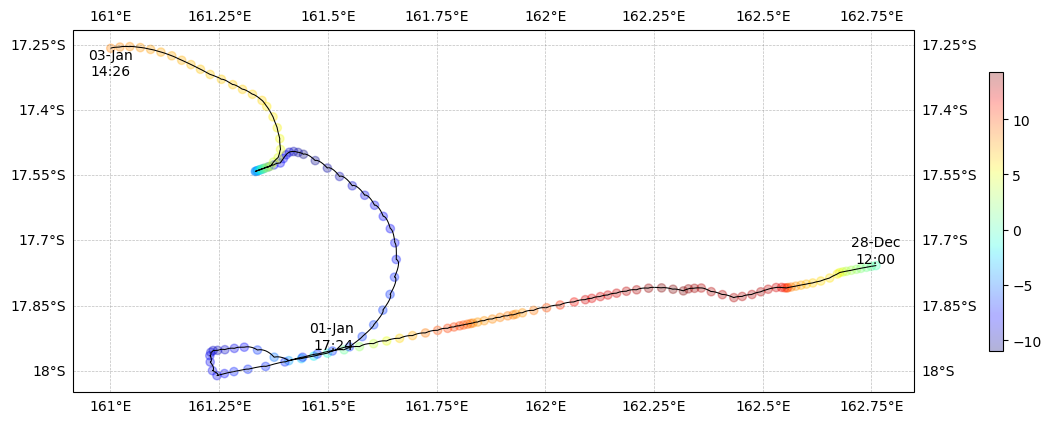

In [20]:
# Set plot size
width = 12
height = 6
plt.rcParams['figure.figsize'] = [width, height]
plt.style.use('seaborn-v0_8-muted') # Setting a style sheet for matplotlib
%matplotlib inline  

# Plot the simulated and actual path of the wave glider along with time error at waypoints.
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
# Set the extent of the plot
# latitude_max, latitude_min, longitude_max, longitude_min = (-17, -18.2, 160, 163.5)
# ax.set_xlim(longitude_min, longitude_max)
# ax.set_ylim(latitude_min, latitude_max)
# Plot map
ax.coastlines(color='grey', linewidth=0.5)
# Plot waypoints
longitudes = df[" Longitude"]
latitudes  = df[" Latitude"]
sc = plt.scatter(x=longitudes, y=latitudes, alpha=0.3, c=df["time_error(hrs)"], cmap=plt.get_cmap("jet"))
plt.colorbar(sc, fraction=0.015, pad=0.08)
# Plot simulated path
longitudes = []
latitudes = []
for point in simulated_path:
    longitude, latitude = epsg.PCS_to_GCS(point.x, point.y)
    longitudes.append(longitude)
    latitudes.append(latitude)
plt.plot(longitudes, latitudes, color='black', linestyle='-', linewidth=0.75, transform=ccrs.Geodetic())
# Create markers for showing time difference
plt.text(df[" Longitude"].tolist()[0], df[" Latitude"].tolist()[0], df["Timestamp(simulated)"].tolist()[0].strftime('%d-%b\n%H:%M'), color="black", ha='center', va='bottom')
plt.text(df[" Longitude"].tolist()[-1], df[" Latitude"].tolist()[-1], df["Timestamp(simulated)"].tolist()[-1].strftime('%d-%b\n%H:%M'), color="black", ha='center', va='top')
plt.text(df[" Longitude"].tolist()[95]-0.02, df[" Latitude"].tolist()[95], df["Timestamp(simulated)"].tolist()[95].strftime('%d-%b\n%H:%M'), color="black", ha='right', va='center')
# plt.show()
plot_path_file = output_dir.joinpath("benjamin_in_freda.png")
plt.savefig(str(plot_path_file), dpi=300)

In [21]:
df["time_error(hrs)"]

0       0.000000
1       0.649367
2       1.241656
3       1.765811
4       2.393033
5       2.954022
6       3.537389
7       4.244644
8       4.962422
9       5.723756
10      5.972967
11      6.177967
12      6.487678
13      6.946344
14      7.493422
15      8.053733
16      8.658167
17      9.385978
18     10.294189
19     11.118644
20     11.866900
21     12.426000
22     12.746144
23     13.035222
24     13.061233
25     13.030489
26     13.201789
27     13.102444
28     13.044778
29     13.082811
30     13.428167
31     13.833989
32     14.270267
33     14.302222
34     14.219722
35     13.790389
36     13.213478
37     12.851033
38     12.518622
39     12.323189
40     12.293178
41     12.127267
42     12.234367
43     11.711989
44     10.778433
45      9.931167
46      8.861300
47      8.040778
48      8.003089
49      8.570122
50      8.709744
51      8.505511
52      8.303744
53      8.015944
54      7.983900
55      8.243444
56      8.887544
57      9.386100
58      9.7738

In [22]:
df["position_error(km)"].describe()

count    147.000000
mean      17.844662
std        8.694050
min        0.049184
25%       12.296877
50%       17.431175
75%       26.307559
max       32.319388
Name: position_error(km), dtype: float64

/home/toby/micromamba/envs/stormexplorers/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


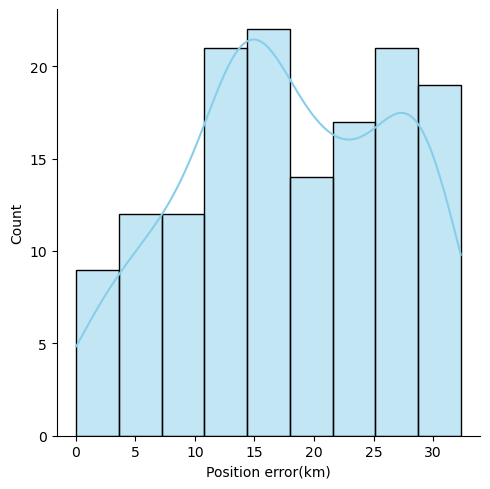

In [23]:
import seaborn as sns
ax = sns.displot(data = df["position_error(km)"], kde=True, color='skyblue')
ax.set(xlabel='Position error(km)')
plot_path_file = output_dir.joinpath("position_errors.png")
plt.savefig(str(plot_path_file), dpi=300)

Time with current
Benjamin simulation progress: : 191it [1:16:32, 24.04s/it]                                                                                                                                                                                  


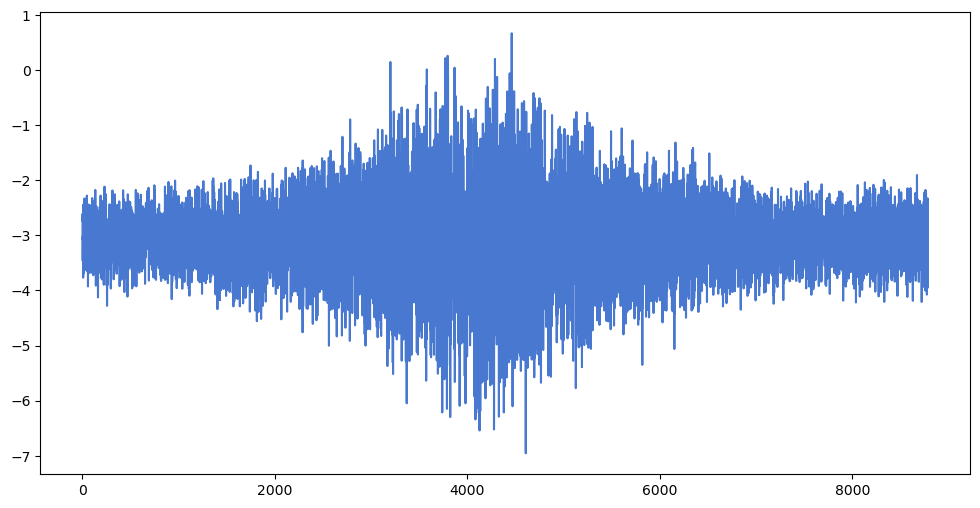

In [24]:
# Plot wave glider heave motion
plt.plot([position.z  for position  in simulated_path])